# Подготовка статистических данных для анализа в Power BI и построения прогнозов с помощью Python(Pandas, Seaborn, SKLearn)
Основная идея проекта состоит в том, чтобы автоматизировать подготовку данных для анализ региональной статистики, информация по которой обновляется ежемесячно Росстатом (по ссылке https://rosstat.gov.ru/folder/11109/document/13259).

Данные включают сотню таблиц в десятках файлах MS Excel, собранных в rar-архив. Таблицы представляют собой матрицы со сводными данными о показателях социально-экономического положения регионов по различным периодам. При этом, если перечень субъектов анализа (регионов/округов) практически идентичен от таблицы к таблице, то периоды и единицы измерения в данных таблицы рознятся.

Так, данные могут быть представлены в виде индексов в %, а также в виде фактических показателей (млн руб., кв.м., квт*ч) и показателей накопленным итогом. Фактические показатели наблюдаются помесячно либо поквартально.
Индексы могут быть представлены в % к соответствующему периоду предыдущего года, в % к предыдущему месяцу и т.д.

### Подготовка таблицы для анализа посредством Pandas

Т.к. использование в исходном виде для составления сводных таблиц в Excel или визуализаций в Power BI затруднительно, с учетом большого количества файлов и таблиц с некоторыми различиями наиболее удобно осуществить обработку массива исходной информации с помощью библиотеки Python Pandas.

Итогом обработки исходных файлов должна стать аналитическая база данных, включающая основную таблицу статистических данных (FactStatistic), а также связанные с ней словари показателей, периодов и регионов. 

В словаре периодов (DimPeriods) собраны варианты наименований периодов на русском языке (отдельные месяцы и кварталы, а также периоды с начала года до соответствующего месяца) для распознавания и номер соответствующего месяца для перевода их в дату (что удобно для последующей навигации по базе данных).

В словаре регионов (DimRegions) собраны все их полные корректные наименования, короткие ключевые наименования для распознавания регионов из исходных таблиц (где наименования могут быть с ошибками и лишними символами), а также индексы регионов и округов соотнесения с таблицей фактов.

В ходе обработки файлов с исходными данными составляется словарь показателей (DimIndexes), включающий наименование статистического показателя ('Индекс промышленного производства', 'Объем инвестиций в основной капитал и т.д.') и способа представления (% к сопоставимому периоду, млн руб., тыс. кв. м. и т.д.).

#### Загрузка библиотек, исходных данных и подготовка словарей



In [1]:
import pandas as pd
import numpy as np
import rarfile
import re
rarfile.UNRAR_TOOL = r'C:\Program Files\WinRAR\UnRAR.exe'

In [2]:
# Загрузка архива с данными.
archive = rarfile.RarFile('Data/info-stat-11-2022.rar', 'r')

# Загрузка словаря периодов.
periods = pd.read_excel('Data/DimPeriods.xlsx')
periods['Period_id'] = periods.index

# Словарь для определения Period_id по исходному наименованию периода.
periods_dict = periods.set_index('PeriodName').to_dict()['Period_id']

# Словарь для определния номера месяца по Period_id.
month_dict = periods.set_index('Period_id').to_dict()['MonthNumber']

# Загрузка словаря регионов.
reg_dict = pd.read_excel('Data/DimRegions.xlsx')

### Подготовка исходного файла
Для сбора таблицы итоговой базы данных и связи ее с таблицами словарей для начала необходимо привести информацию каждой из исходных таблиц к общему формату, предполагающему наличие следующих данных: 
* 'Region_id', идентификатор региона/округа (int);
- 'Index', статистический показатель (float);
- 'Period', временная метка периода в формате datetime;
- 'Period_id', идентификатор периода (int);
- 'Index_id', идентификатор статистического показателя (int).

В ходе подготовки итоговой таблицы следует удалить из исходных данных агрегированные строки с Архангельской областью и Тюменской областью с учетом автономных округов, с учетом того, что в данных есть показатели и по каждому из данных субъектов в отдельности. Агрегированные при этом для расчета рэнкинга и анализа статистики на практике не используются.
Еще одной задачей на том этапе является объединение данных Забайкальского края и Республики Бурятии в одну строку с сохранением всех данных. В ряде случаев эти данные в двух отдельных строках: до 2018 года в разделе СФО и далее с 2018 года в ДВФО.

Кроме того, предобработка включает очистку данных от лишних символов, заполнение пустых значений, а также исправление наименований регионов и периодов содержащих ошибки.
    

In [3]:
from jellyfish import damerau_levenshtein_distance as dld


def clear_word(word):
    '''
    Функция для очистки слова от лишних символов
    '''
    return re.sub(r' +', r' ', re.sub(r'[^-IVа-яА-Я/. ]+', '', word.strip()))


def right_period(word):
    '''
    Функция для определения Period_id ближайшего похожего наименования периода
    в случае наличия ошибок в названии периода

    '''
    min_dist_idx = periods.PeriodName.apply(lambda x: dld(word, x)).idxmin()
    return periods.Period_id.loc[min_dist_idx]


def prepare_period(df):
    '''
    Функция подготовки строки с датой
    '''
    df.iloc[0, :] = df.iloc[0, :].ffill()
    per_year = df.iloc[0, :].apply(lambda x: x.split()[0])
    per_name = df.iloc[1, :].apply(clear_word)
    # Определение индекса периода и номера месяца.
    per_id = per_name.apply(lambda x: periods_dict.get(x, right_period(x)))
    per_month = per_id.apply(lambda x: str(month_dict.get(x)))
    # Определение агрегированной строки с периодом и индексом периода.
    period = per_year + '-' + per_month + '_' + per_id.astype('str')
    period[0] = 'Region_id'
    return period


def merge_duplicates(df):
    '''
    Функция для объединения данных в строках с дубликатами регионов
    '''
    duplicated_first = df[df[0].duplicated(keep='last')].index.values
    duplicated_last = df[df[0].duplicated()].index.values
    for first, last in zip(duplicated_first, duplicated_last):
        df.loc[last, :] = df.loc[last, :].fillna(df.loc[first, :])
        df.drop(index=first, inplace=True)
    return df


def right_region(name):
    '''
    Функция для определения индекса региона

    '''
    name = name.replace('г.', '').split()
    return reg_dict.query('Region_short in @name').Region_id.values[0]


def df_transform(data):
    '''
    Функция для подготовки отдельной исходной таблицы в Excel
    для дальнейшей интеграции в общую таблицу базы данных
    '''
    # Определение индекса строки начала таблицы по первому пропуску.
    start_index = data[data[0].isna()].index[0]

    # Удаление пустых колонок, с учетом попадания мусорных данных.
    df = data.dropna(axis='columns', thresh=2).copy(deep=True)

    # Разделение заголовка таблицы на название индекса и его описание.
    df_title_main = clear_word(df.loc[0, 0])
    df_title_unit = clear_word('_'.join(df[1:start_index][0].to_list()))

    # Выделение строки с периодом и таблицы со статистическими данными.
    period = prepare_period(df.loc[start_index:start_index+1, 1:])
    reg_df = df.loc[start_index+2:].dropna(thresh=2)

    # Определение соответствующих индексов регионов через словарь.
    reg_names = reg_df[0].apply(clear_word)
    reg_df[0] = reg_names.apply(right_region)

    # Объединение данных дублированных регионов.
    reg_df = merge_duplicates(reg_df)

    # Развертывание исходной сводной таблицы в "длинный" формат.
    reg_df.columns = period.sort_index()
    data = reg_df.melt(id_vars=['Region_id'],
                       var_name='Period',
                       value_name='Index')
    data.Index = data.Index.apply(lambda x: re.sub((r'-|\.\.\.|\…| '), '0',
                                                   str(x).replace(',', '.')))

    # Развертывание колонок с датой и идентификатором периода.
    data = pd.concat([data, data.Period.str.split('_', expand=True)], axis=1)
    data.drop(columns='Period', inplace=True)
    data.rename(columns={0: 'Period', 1: 'Period_id'}, inplace=True)

    # Функция возвращает предобработанную таблицу,
    # полное наименование таблицы и описание индекса.
    return data, df_title_main, df_title_unit

### Сбор итоговой базы данных
В рамках сбора итоговой таблицы осуществляется проход по файлам в архиве и выбор файлов формата *.xls, *.xlsx, с учетом списка исключений, содержащим индексы файлов, которые не подходят под общий формат. С помощью функции df_transform преобразуются таблицы каждого листа загружаемого файла и добавляются в общую итоговую таблицу.
Параллельно формируется таблица словаря показателей.

In [4]:
%%time
# Список исключений.
stoplist = ['12-02', '12-03', '12-04', '12-05', '13-01', '15-01']

# Маска для определения индекса файлов.
id_mask = r'/\d\d-\d\d'

# Типы файлов для загрузки.
file_types = ['xls', 'lsx']

# Создание таблицы для сбора итоговой базы данных.
result_df = pd.DataFrame(columns=['Region_id',
                                  'Index',
                                  'Period',
                                  'Period_id',
                                  'Index_id'])

# Создание таблицы для сбора наименований индексов.
idx_df = pd.DataFrame(columns=['IndexTitle',
                                 'IndexUnit',
                                 'SheetName'])
index_id = -1

# Проход по файлам в архиве.
for name in archive.namelist():
    if name[-3:] in file_types:
        if re.search(id_mask, name).group()[1:] not in stoplist:
            xlfile = archive.open(name)
            data_file = pd.ExcelFile(xlfile)

            # Проход по каждому листу файла.
            for sheet in data_file.sheet_names:
                data_sheet = data_file.parse(sheet, header=None)
                temp_df, title, unit = df_transform(data_sheet)

                # Добавление показателя в таблицу индексов.
                index_id += 1
                idx_df.loc[index_id, :] = [title, unit, sheet]

                # Добавление колонки с идентификатором показателя.
                temp_df['Index_id'] = index_id

                # Добавление показателя в общую таблицу.
                result_df = pd.concat([result_df, temp_df],
                                      ignore_index=True)

# Перевод данных итоговой таблицы в соответствующие форматы.
result_df.Period = result_df.Period.astype('datetime64')
result_df.Period_id = result_df.Period_id.astype('int')
result_df.Index_id = result_df.Index_id.astype('int')
result_df.Region_id = result_df.Region_id.astype('int')
result_df.Index = result_df.Index.astype('float').fillna(0)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612316 entries, 0 to 612315
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Region_id  612316 non-null  int32         
 1   Index      612316 non-null  float64       
 2   Period     612316 non-null  datetime64[ns]
 3   Period_id  612316 non-null  int32         
 4   Index_id   612316 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3)
memory usage: 16.4 MB
CPU times: total: 21.3 s
Wall time: 32 s


#### Форматирование таблицы наименований индексов
Сформированная таблица словаря показателей требует доработки. Во-первых это заполнение значений наименований индексов: вместо "продолжение", которое обозначается на всех листах книги, кроме заглавного. Во вторых унификация представлений показателей с учетом большого количества изначальных описаний, различающихся порой незначительно и содержащих мелкие ошибки.

С учетом большого количества различных вариантов представлений индексов, а также наличия ошибок и мелких отличий в их описании для унификации и упрощения навигации добавляется колонка со значениями единиц измерения в общем формате

In [5]:
# Наименование индексов вместо "продолжение".
idx_df.IndexTitle = idx_df.IndexTitle.replace('продолжение', np.nan).ffill()

# Общее количество отдельных индексов (с учетом разных представлений каждого):
print('Всего таблиц:', idx_df.shape[0])
print('Всего индексов:', idx_df.IndexTitle.unique().size)
print('Всего представлений:', idx_df.IndexUnit.unique().size)

Всего таблиц: 101
Всего индексов: 50
Всего представлений: 46


In [6]:
# Загрузка подготовленной таблицы с 14 унифицированными единицами измерения.
units_idxs = pd.read_excel('data/IndexUnits.xlsx')
# units_idxs.index.name = 'Unit_id'


def right_unit(word):
    # Функция для поиска наиболее подходящего значения единицы измерения.
    min_idx = units_idxs.IndexUnitFull.apply(lambda x: dld(word, x)).idxmin()
    return min_idx


# Для поиска выбираются крайние справа значения в строке описания индекса
idx_unit = idx_df.IndexUnit.apply(lambda x: x.split('_')[-1].split(';')[-1])
idx_df['IndexUnit_id'] = idx_unit.apply(right_unit)

# Добавление унифицированных описаний индексов в общую таблицу.
idx_df = idx_df.join(units_idxs, on='IndexUnit_id')

# Общее количество представлений индексов сокращено:
idx_g = idx_df.groupby('IndexUnitFull').size().sort_values(ascending=False)
print('Всего представлений:', idx_df.IndexUnit.unique().size)
print('Унифицированных представлений:', idx_df.IndexUnitFull.unique().size)
print('Распределение способов представлений:\n\n', idx_g)

Всего представлений: 46
Унифицированных представлений: 13
Распределение способов представлений:

 IndexUnitFull
В % к соответствующему периоду предыдущего года    21
В % к соответствующему месяцу предыдущего года     15
В % к декабрю предыдущего года                     12
Рабочие места, тыс. человек                        12
В % к предыдущему месяцу                           11
Млн рублей                                          9
Млн долларов США                                    6
Объем просроченной задолженности, млн рублей        5
Тыс. кв. метров общей площади жилых помещений       3
В % к общему количеству                             2
Рублей                                              2
Рублей за кв. метр общей площади                    2
Млн кВт*ч                                           1
dtype: int64


#### Выгрузка результата и словарей
Выгрузка в один файл xlsx результата и словарей удобна для дальнейшего использования в PowerBI либо непосредственно в Excel, занимает немного меньше места, но требует значительно больше времени, чем сохранение в csv.

In [7]:
%%time
with pd.ExcelWriter('Data/result_df.xlsx') as writer:
    result_df.to_excel(writer, sheet_name='FactStatistic')
    idx_df.to_excel(writer, sheet_name='DimIndexes')
    reg_dict.to_excel(writer, sheet_name='DimRegions')
    periods.to_excel(writer, sheet_name='DimPeriods')

import os
f_size = os.path.getsize('Data/result_df.xlsx')
print('Размер файла: {:.2f}'.format(f_size*10**-6), 'Мб')

Размер файла: 17.96 Мб
CPU times: total: 1min 40s
Wall time: 1min 43s


## Построение визуализации 
На основе подготовленных данных можно построить визуализации с помощью библиотеки Seaborn.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Столбчатая диаграмма - основная, которую можно использовать в целях обзора временных рядов показателей региональной статистики. Далее приведены графики для ряда показателей регионов Ангаро-Енисейского макрорегиона: Республики Тывы, Республики Хакасия, Красноярского края и Иркутской области.
1. Индекс промышленного производства, в % к соответствующему периоду предыдущего года за 2022 год.
2. Индекс промышленного производства Красноярского края за 2022 год, в % к предыдущему месяцу и соответствующему месяцу предыдущего года. 
3. Объем инвестиций в основной капитал, в млн рублей.

In [9]:
def get_sample(df, index_idxs, region_idxs, year):
    '''
    Функция подготовки выборки определенных регионов,
    показателей и периодов (годов) из базы данных таблицы
    '''
    sample = df.query('Index_id in @index_idxs & Region_id in @region_idxs')
    sample = sample.query('Period.dt.year == @year')
    regions = reg_dict.drop(columns='Region_short').set_index('Region_id')
    sample = sample.join(regions, on='Region_id')
    sample = sample.join(idx_df, on='Index_id')
    sample = sample.join(periods.set_index('Period_id'), on='Period_id')
    return sample


def regions_barplt(result_df, index_idxs, region_idxs, year):
    '''
    Функция построения столбчатой диаграммы
    для нескольких регионов по одному показателю
    либо нескольких показателей по одному региону за определенный год
    '''
    sample_df = get_sample(result_df, index_idxs, region_idxs, year)
    sns.set_theme()
    plt.figure(figsize=(16, 6))
    font = {'family': 'Verdana',
            'color':  'darkred',
            'weight': 'normal',
            'size': 14}

    if len(index_idxs) == 1:
        # Диаграмма по одному показателю для нескольких регионов
        ax = sns.barplot(y='Index',
                         x='PeriodName',
                         data=sample_df,
                         hue='Region_full')
        descr = ',\n' + sample_df.IndexUnitFull.iloc[0].lower()
    elif len(region_idxs) == 1:
        # Диаграмма для одного региона по нескольким показателям
        ax = sns.barplot(y='Index',
                         x='PeriodName',
                         data=sample_df,
                         hue='IndexUnitFull')
        descr = ',\n' + sample_df.Region_full.iloc[0]
    else:
        print('Нет возможности построить график в данной конфигурации')
        return

    if sample_df.shape[0] > 12:
        for bar in ax.containers:
            ax.bar_label(bar, rotation=90,
                         label_type='center',
                         color='w',
                         size=13)
    else:
        for bar in ax.containers:
            ax.bar_label(bar, size=13, padding=1, fmt='%d')

    sns.move_legend(ax, "lower center",
                    bbox_to_anchor=(0.8, 1),
                    ncol=2,
                    title=None,
                    frameon=False)
    ax.set_title(sample_df.IndexTitle.iloc[0] + descr,
                 fontdict=font, loc='left')
    ax.set_xlabel(str(year) + ' год')
    ax.set_ylabel('')
    return plt.show()

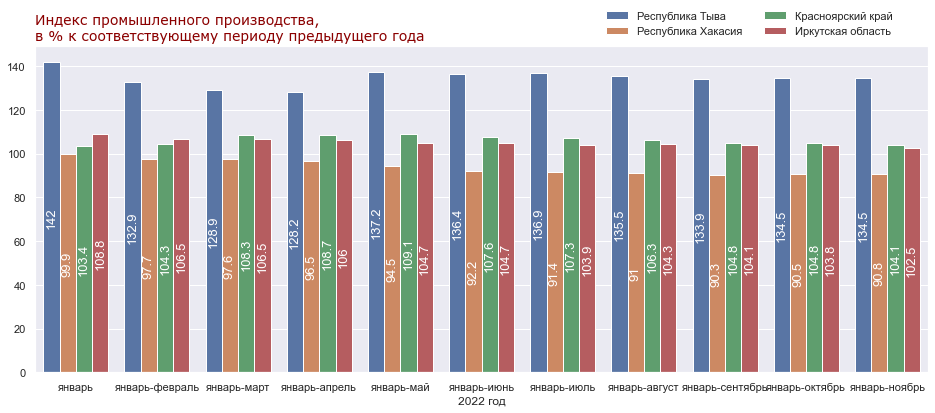

In [10]:
index_idxs = [1]
region_idxs = [75, 76, 78, 79]
year = 2022
regions_barplt(result_df, index_idxs, region_idxs, year)

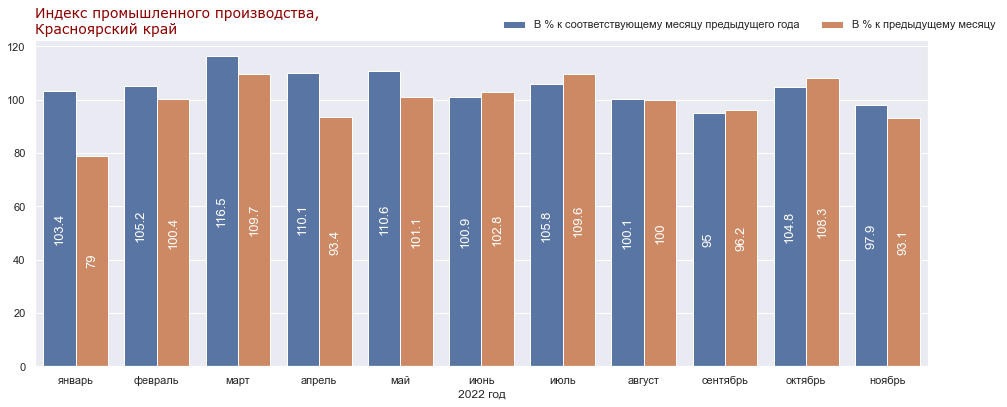

In [11]:
index_idxs = [0, 2]
region_idxs = [78]
year = 2022
regions_barplt(result_df, index_idxs, region_idxs, year)

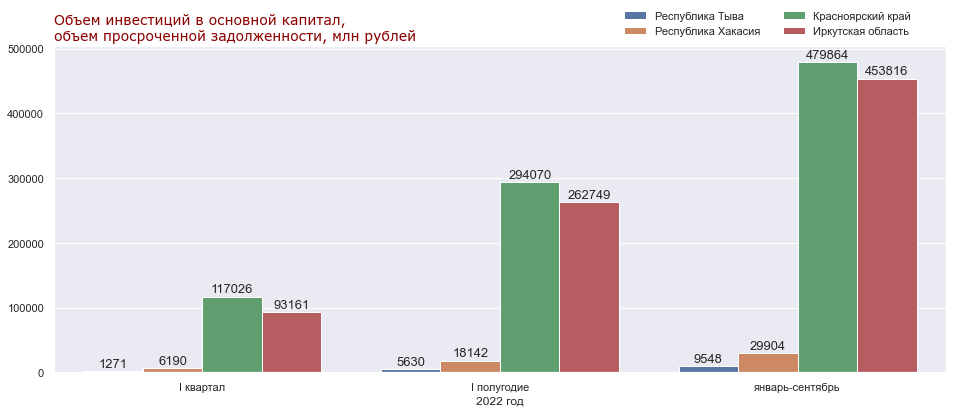

In [12]:
index_idxs = [56]
region_idxs = [75, 76, 78, 79]
year = 2022
regions_barplt(result_df, index_idxs, region_idxs, year)

Достаточно удобными для анализа могут быть комбинированные графики, отображающие один показатель в фактическом выражении и один в процентном. Ниже представлены графики регионов АЕМР, где отображены данные об объеме инвестиций в основной капитал, в млн рублей по одной вертикальной оси и параллельно динамику в сопоставлении с предыдущим периодом прошлого года в процентном выражении.

In [13]:
def regions_twinplt(df,
                    index_idx_fact,
                    index_idx_percent,
                    region_idxs,
                    year):
    '''
    Функция построения комбинированной диаграммы
    '''
    # Подготовка выборок для графиков
    sample_l = get_sample(df, index_idx_fact, region_idxs, year)
    sample_r = get_sample(df, index_idx_percent, region_idxs, year)

    sns.set_theme(style='white')

    # Определение количества рядов в графике
    num_rows = int(np.ceil(len(region_idxs)/2))
    # Определение области построения графиков
    fig, axs = plt.subplots(ncols=2,
                            nrows=num_rows,
                            figsize=(16, 4*num_rows),
                            squeeze=False,
                            constrained_layout=True)
    # Заголовок графика
    fig.suptitle(sample_l.IndexTitle.iloc[0])

    for ax_, reg_id in list(zip(axs.ravel(), region_idxs)):
        # Построение графиков в фактическом выражении
        data_l = sample_l.query('Region_id == @reg_id')
        ax_ = sns.barplot(ax=ax_,
                          y='Index',
                          x='PeriodName',
                          data=data_l)
        ax_.set_title(data_l.Region_full.iloc[0])
        ax_.bar_label(ax_.containers[0],
                      size=14,
                      padding=-18,
                      fmt='%.f')
        ax_.set_xlabel('')
        ax_.set_ylabel(sample_l.IndexUnitShort.iloc[0])
        ax_.grid(visible=None)
        ax_.set_xticks([])

        # Построение графиков в процентном выражении
        data_r = sample_r.query('Region_id == @reg_id')
        ax_t = ax_.twinx()
        ax_t.set_ylim(bottom=0,
                      top=data_r.Index.max()*1.2,
                      emit=True,
                      auto=False)
        sns.pointplot(ax=ax_t,
                      data=data_r,
                      x='PeriodName',
                      y='Index')
        ax_t.set_ylabel(sample_r.IndexUnitShort.iloc[0])
        for xy in ax_t.collections[0].get_offsets():
            ax_t.annotate(xy[1],
                          (xy[0], xy[1] + 5),
                          color='darkblue')

    return plt.show()

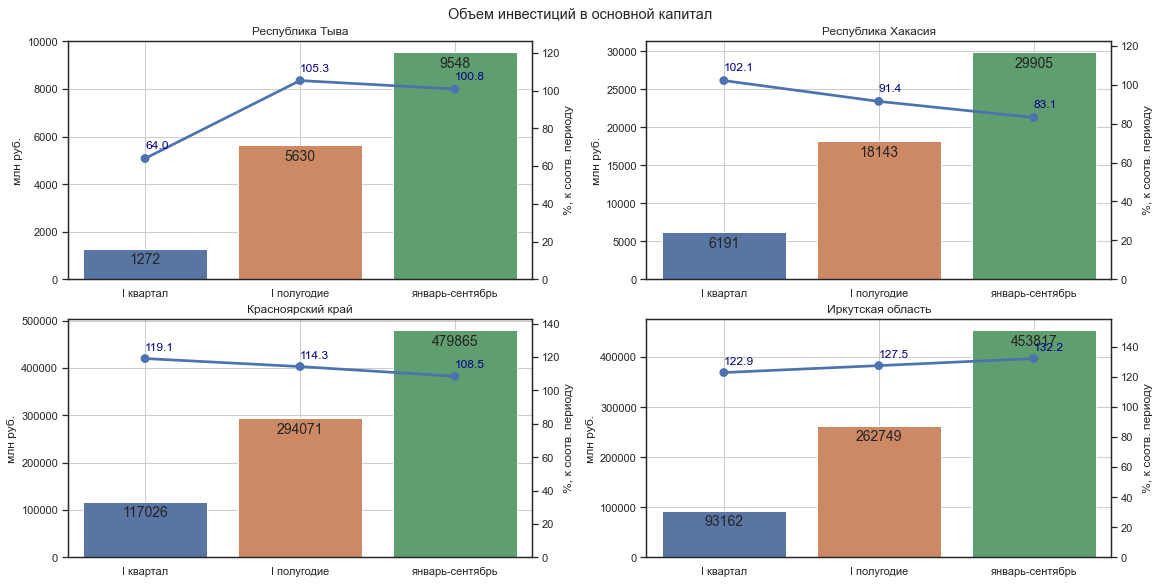

In [14]:
idx_fact = [56]
idx_percent = [57]
region_idxs = [75, 76, 78, 79]
year = 2022
regions_twinplt(result_df, idx_fact, idx_percent, region_idxs, year)

Подготовленный файл также удобно использовать в рамках разнообразных аналитических инструментов, в том числе в Power BI. Пример отчета представлен ниже и по [ссылке](https://github.com/islavunin/regional_statistics/blob/main/data/Regional_statistic.pbix "Файл отчета PowerBI").
<img src = 'Regional_statistics.png'>

## Построение прогнозов статистических показателей
На базе подготовленного датасета можно также осуществить прогноз показателей.
В качестве примера возьмем выборку по показателю "Объем инвестиций в основной капитал" по Красноярскому краю.

In [15]:
drop_cols = ['Period_id', 'Region_id', 'Index_id']
sample = result_df.query('Region_id == 78 & Index_id == 56').copy()
sample = sample.drop(columns=drop_cols).reset_index(drop=True)
# Добавление характеристики года и квартала.
sample['Year'] = sample.Period.dt.year
sample['Quarter'] = sample.Period.dt.quarter
# Определение квартального прироста показателя.
sample['IndexPerQ'] = sample.Index - sample.Index.shift(1, fill_value=0)
sample.IndexPerQ = sample.IndexPerQ.mask(sample.IndexPerQ < 0, sample.Index)
# В качестве целевого показателя определяется показатель следующего периода.
sample['x'] = sample.IndexPerQ
sample['y'] = sample.IndexPerQ.shift(-1)

В рамках прогноза предполагается оценить эффективность прогнозирования следующих алгоритмов: линейной регрессии, дерева решений, леса деревьев решений, а также градиентного бустинга на базе библиотеки SciKitLearn, а также регрессионного алгоритма библиотеки Xgboost. Для целей первичной оценки алгоритмы используются без настройки гиперпараметров. В качестве базовой оценки (бенчмарка) взят показатель предыдущего периода.
В качестве метрики ошибок для оценки точности прогнозирования временных рядов выбрана МАРЕ - средняя абсолютная ошибка в процентах.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb


def mape(y_true, y_pred):
    # Функция расчета средней абсолютной ошибки
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


def predict_values_MAPE(train, test, column):
    # Функция выводит результат предсказания 5 алгоритмов
    # в сравнении с базовой оценкой
    
    indexes = ['Y', 'Y[-1]', 'Y[-1], %', 'LR', 'LR, %', 'DT', 'DT, %',
               'RF', 'RF, %', 'GB', 'GB, %', 'XGB', 'XGB, %']
    
    y_train = train.y.values.reshape(-1, 1)
    X_train = train.drop(['y'], axis=1)
    prev_x_test = test.x.values.reshape(-1, 1)
    y_test = test.y.values.reshape(-1, 1)
    X_test = test.drop(['y'], axis=1)

    lm = LinearRegression()
    lm.fit(X_train, y_train)
    lm_predict = lm.predict(X_test)

    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_train, y_train)
    tree_predict = tree.predict(X_test)

    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train.ravel())
    rf_predict = rf.predict(X_test)

    gb = GradientBoostingRegressor(random_state=42)
    gb.fit(X_train, y=y_train.ravel())
    gb_predict = gb.predict(X_test)

    xgb_r = xgb.XGBRegressor(seed=42)
    xgb_r.fit(X_train, y_train)
    xgb_predict = xgb_r.predict(X_test)

    result = pd.DataFrame(data=[y_test[0][0],
                                prev_x_test[0][0], mape(y_test, prev_x_test),
                                lm_predict[0][0], mape(y_test, lm_predict),
                                tree_predict[0], mape(y_test, tree_predict),
                                rf_predict[0], mape(y_test, rf_predict),
                                gb_predict[0], mape(y_test, gb_predict),
                                xgb_predict[0], mape(y_test, xgb_predict)],
                                columns=[column], index=indexes)
    return result

С учетом ограниченной выборки в тренировочный датасет включена информация за 2016-2020 года, в валидационный - информация с начала 2021 года. Если строить прогноз только на данных предыдущего периода наилучшую точность показывает предыдущий период :)

In [17]:
def show_results(sample, cols):
    title_col = 'MAPE, %'
    show_rows = ['Y[-1], %', 'LR, %', 'DT, %', 'RF, %', 'GB, %', 'XGB, %']
    idx_dict = {'Y[-1], %': 'Предыдущий период (Y[-1])',
                'LR, %': 'Linear Regression (LR)',
                'DT, %': 'Decision Tree (DT)',
                'RF, %': 'Random Forest (RF)',
                'GB, %': 'Gradient Boosting (GB)',
                'XGB, %': 'XGBoost Regressor (XGB)'}
    train = sample[cols][:-7]
    test = sample[cols][-7:-1]
    result = predict_values_MAPE(train, test, title_col)
    return result.loc[show_rows].rename(index=idx_dict)

In [18]:
pred_cols = ['x', 'y']
show_results(sample, pred_cols)

,"MAPE, %"
Предыдущий период (Y[-1]),32.89
Linear Regression (LR),37.15
Decision Tree (DT),46.66
Random Forest (RF),41.31
Gradient Boosting (GB),46.57
XGBoost Regressor (XGB),46.66


При добавлении в датасет данных о годе и квартале немного лучший результат показывают Random Forest и Gradient Boosting, однако величина ошибки по метрике МАРЕ все еще очень велика.

In [19]:
pred_cols = ['Year', 'Quarter', 'x', 'y']
show_results(sample, pred_cols)

,"MAPE, %"
Предыдущий период (Y[-1]),32.89
Linear Regression (LR),57.78
Decision Tree (DT),44.45
Random Forest (RF),26.55
Gradient Boosting (GB),25.81
XGBoost Regressor (XGB),34.55


Расширение датасета путем преобразования категориальной переменной Quarter в dummy-переменные дает заметный прирост в качестве прогноза линейной регрессии, но в целом ошибка также велика как и раньше.

In [20]:
dum_sample = pd.get_dummies(data=sample, prefix='q', columns=['Quarter'])
pred_cols = ['x', 'y', 'q_1', 'q_2', 'q_3', 'q_4']
show_results(dum_sample, pred_cols)

,"MAPE, %"
Предыдущий период (Y[-1]),32.89
Linear Regression (LR),20.97
Decision Tree (DT),44.65
Random Forest (RF),40.02
Gradient Boosting (GB),41.69
XGBoost Regressor (XGB),42.40


Для улучшения прогноза соберем сводную таблицу по годам, с помощью которой на базе 3-х кварталов будем прогнозировать четвертый. С учетом ограниченности выборки проведем кросс-валидацию по отдельным объектам (Leave-One-Out).
Результат прогнозирования будет сведен в общую таблицу с результатом прогноза и оценкой его ошибки по каждому году и каждому алгоритму.

In [21]:
from sklearn.model_selection import LeaveOneOut


def mape_llo(sample):
    # Функция выводит результаты кросс-валидации LOO
    loo = LeaveOneOut()
    columns = ['Y', 'Y[-1]', 'Y[-1], %', 'LR', 'LR, %', 'DT', 'DT, %',
               'RF', 'RF, %', 'GB', 'GB, %', 'XGB', 'XGB, %']
    mape_results = pd.DataFrame(columns=columns)
    for train_id, test_id in loo.split(sample):
        train = sample.iloc[train_id]
        test = sample.iloc[test_id]
        result = predict_values_MAPE(train, test, test.index[0])
        mape_results = pd.concat([mape_results, result.T])
    return mape_results

In [22]:
%%time
# Подготовка сводной таблицы по годам
pvt_sample = sample.pivot(index='Year', columns='Quarter', values='IndexPerQ')
pvt_sample.rename(columns={1:'x1', 2:'x2', 3:'x', 4:'y'}, inplace=True)
# Формат вывода чисел
pd.options.display.float_format ='{:,.1f}'.format
pvtq_results = mape_llo(pvt_sample[:-1])
# Вывод таблицы результатов MAPE базовых алгоритов
show_cols = ['LR, %', 'DT, %', 'RF, %', 'GB, %', 'XGB, %']
print('Результаты прогнозирования базовых алгоритмов (MAPE):')
pvtq_results[show_cols]

Результаты прогнозирования базовых алгоритмов (MAPE):
CPU times: total: 4.67 s
Wall time: 1.15 s


,"LR, %","DT, %","RF, %","GB, %","XGB, %"
2016,2.2,10.3,19.2,11.0,20.0
2017,18.0,14.9,3.5,9.0,3.7
2018,3.6,3.9,1.1,0.1,5.2
2019,33.5,9.3,0.8,9.3,8.4
2020,12.0,19.2,21.0,20.0,16.2
2021,51.2,5.1,17.7,5.1,17.2


In [23]:
# Агрегация результатов предсказаний базовых алгоритмов
aggcols = ['LR', 'DT', 'RF', 'GB', 'XGB']
pvtq_results['AVG'] = pvtq_results[aggcols].mean(axis=1)
pvtq_results['MIN'] = pvtq_results[aggcols].min(axis=1)
pvtq_results['MAX'] = pvtq_results[aggcols].max(axis=1)
pvtq_results['MED'] = pvtq_results[aggcols].median(axis=1)
# Вывод усредненных показателей моделей
for c in pvtq_results.columns:
    if '%' not in c:
        print(c + ':', mape(pvtq_results.Y, pvtq_results[c]), '%')

Y: 0.0 %
Y[-1]: 35.22 %
LR: 20.07 %
DT: 10.43 %
RF: 10.54 %
GB: 9.08 %
XGB: 11.78 %
AVG: 5.92 %
MIN: 11.72 %
MAX: 23.09 %
MED: 8.08 %


#### Результат прогноза
Кросс-валидация показала, что качество прогноза алгоритмов сильно различается от года к году: где-то лучшим выступает градиентный бустинг, а где-то простая линейная регрессия.
Если посмотреть на ошибку агрегированных результатов по всем алгоритмам (ниже), среднее значение из всех прогнозов показывает наименьшую ошибку. Соответственно можно сделать вывод, что с учетом ограниченности данных средний показатель ансамбля алгоритмов "из коробки" имеет наилучшее качество (5,92%). Таким образом, ансамбль базовых алгоритмов, с учетом его высокой производительности и отсутствия необходимости настройки под каждый отдельный индекс, может быть эффективно применим для прогнозирования временных рядов большого количества показателей при малом количества данных.